In [1]:
import os
os.environ['CC'] = 'gcc'
os.environ['CXX'] = 'g++'

import sys
sys.path.append('..')

import jax
import jax.numpy as jnp
import spark
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

# NOTE: Brian throws an error if we don't set a device 
#b2.set_device('cpp_standalone', build_on_run=False)

In [ ]:
def spikes_to_current(spike_times, k=1.0, t_max=100.0, dt=0.1):
    """
    	Convert spike times into a discrete current trace.
    """
    times = np.arange(0, t_max + dt, dt)
    currents = np.zeros_like(times)
    for s in spike_times:
        idx = int(round(s / dt))
        if 0 <= idx < len(currents):
            currents[idx] += k
    return times, currents

def simulate_LIF_from_spikes(
		spike_times,
		synapse_strength,
		t_max,
		dt,
		v_rest,
		v_reset,
		firing_threshold,
		membrane_resistance,
		membrane_time_scale,
		abs_refractory_period,
	):
	"""
		Simulate a LIF neuron receiving discrete one-step current inputs from spikes.
	"""
	
	# Reset scope
	b2.start_scope()
	# Build discrete current trace from spikes
	times, currents = spikes_to_current(spike_times, k=synapse_strength, t_max=t_max, dt=dt)
	input_current = b2.TimedArray(currents * b2.nA, dt=dt * b2.ms)
	# Build model
	eqs = """
		dv/dt = (-(v - v_rest) + membrane_resistance * input_current(t)) / membrane_time_scale : volt (unless refractory)
	"""
	neuron = b2.NeuronGroup(
		1, model=eqs, reset="v=v_reset", threshold="v>firing_threshold",
		refractory=abs_refractory_period, method="linear"
	)
	# Initialization
	neuron.v = v_rest
	# Monitors
	state_monitor = b2.StateMonitor(neuron, "v", record=True)
	spike_monitor = b2.SpikeMonitor(neuron)
	# Run simulation
	b2.run(t_max * b2.ms)
	# Get outputs
	times = state_monitor.t / b2.ms
	spikes = [s / b2.ms for s in spike_monitor.t]
	potentials = state_monitor.v[0] / b2.mV
	return times, potentials, spikes

In [ ]:
def spikes_to_current(spike_times, k=1.0, t_max=100.0, dt=0.1):
    """
    	Convert spike times into a discrete current trace.
    """
    times = np.arange(0, t_max + dt, dt)
    currents = np.zeros_like(times)
    for s in spike_times:
        idx = int(round(s / dt))
        if 0 <= idx < len(currents):
            currents[idx] += k
    return times, currents

def spike_events_to_array(spikes, max_t, dt=0.1):
	times = np.linspace(0, max_t, int(max_t/dt)+1)
	array = np.zeros(times.shape)
	for s in spikes:
		array[int(s / dt)] = 1
	return times, array

@jax.jit
def run_model_split(graph, state, **inputs):
	model = spark.merge(graph, state)
	outputs = model(**inputs)
	_, state = spark.split((model))
	return outputs, state

In [ ]:
def simulate_LIF_from_spikes(
		spike_times,
		synapse_strength,
		t_max,
		dt,
		v_rest,
		v_reset,
		firing_threshold,
		membrane_resistance,
		membrane_time_scale,
		abs_refractory_period,
	):
	"""
		Simulate a LIF neuron receiving discrete one-step current inputs from spikes.
	"""
	
	# Reset scope
	b2.start_scope()
	# Build discrete current trace from spikes
	times, currents = spikes_to_current(spike_times, k=synapse_strength, t_max=t_max, dt=dt)
	input_current = b2.TimedArray(currents * b2.nA, dt=dt * b2.ms)
	# Build model
	eqs = """
		dv/dt = (-(v - v_rest) + membrane_resistance * input_current(t)) / membrane_time_scale : volt (unless refractory)
	"""
	neuron = b2.NeuronGroup(
		1, model=eqs, reset="v=v_reset", threshold="v>firing_threshold",
		refractory=abs_refractory_period, method="linear"
	)
	# Initialization
	neuron.v = v_rest
	# Monitors
	state_monitor = b2.StateMonitor(neuron, "v", record=True)
	spike_monitor = b2.SpikeMonitor(neuron)
	# Run simulation
	b2.run(t_max * b2.ms)
	# Get outputs
	times = state_monitor.t / b2.ms
	spikes = [s / b2.ms for s in spike_monitor.t]
	potentials = state_monitor.v[0] / b2.mV
	return times, potentials, spikes

In [ ]:

# Build neuronal model
def build_lif_model(
	dt,
	synapse_strength,
	potential_rest,
	potential_reset,
	potential_tau,
	resistance,
	threshold,
	cooldown,
):
	# NOTE: We need to substract 1 timestep from the cooldown to match the Brian2 dynamic 
	# Since we update the refractory the period at the end of the cycle, Brian2 does it at the begining. 
	lif_neuron = spark.nn.neurons.LIFNeuron(
		_s_units = (1,),
		_s_dt = dt,
		_s_dtype = jnp.float16,
		inhibitory_rate = 0.0,
		soma_config = spark.nn.somas.StrictRefractoryLeakySomaConfig(
			potential_rest = potential_rest,
			potential_reset = potential_reset,
			potential_tau = potential_tau,
			resistance = resistance / 1000, # MΩ -> GΩ
			threshold = threshold,
			cooldown = cooldown - dt, 
		),
		synapses_config = spark.nn.synapses.LinearSynapsesConfig(
			units = (1,),
			kernel_initializer = spark.nn.initializers.ConstantInitializerConfig(scale=synapse_strength),
		),
		delays_config = None,
		learning_rule_config = None,
	)
	lif_neuron(in_spikes=spark.SpikeArray( jnp.zeros((1,)) ))
	return lif_neuron

In [3]:
DT = 0.1
V_REST = -70.0
V_RESET = -65.0
FIRING_THRESHOLD = -50
MEMBRANE_RESISTANCE = 10.0
MEMBRANE_TIME_SCALE = 8.0
ABSOLUTE_REFRACTORY_PERIOD = 2.0
INPUT_SPIKE_TIMES = [10, 20, 30, 32, 34, 36, 38, 55, 60, 62, 70, 84]
SYNAPSE_STRENGTH = 75.0

In [5]:
# Run Brian2 model
b2_times, b2_potentials, b2_spikes = simulate_LIF_from_spikes(
	INPUT_SPIKE_TIMES,
	synapse_strength=SYNAPSE_STRENGTH,
	t_max=100.0,
	dt=DT,
	v_rest=V_REST * b2.mV,
	v_reset=V_RESET * b2.mV,
	firing_threshold=FIRING_THRESHOLD * b2.mV,
	membrane_resistance=MEMBRANE_RESISTANCE * b2.Mohm,
	membrane_time_scale=MEMBRANE_TIME_SCALE * b2.ms,
	abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD * b2.ms
)

# Run Spark model
lif_neuron = build_lif_model(
	dt = DT,
	synapse_strength = SYNAPSE_STRENGTH,
	potential_rest = V_REST,
	potential_reset = V_RESET,
	potential_tau = MEMBRANE_TIME_SCALE,
	resistance = MEMBRANE_RESISTANCE, # MΩ -> GΩ
	threshold = FIRING_THRESHOLD,
	cooldown = ABSOLUTE_REFRACTORY_PERIOD - DT,
)
graph, state = spark.split((lif_neuron))
spark_times, in_spikes = spike_events_to_array(INPUT_SPIKE_TIMES, 100, dt=DT)
spark_spikes, spark_potentials = [], []
refractory_value = []
for s in in_spikes:
	in_spikes = spark.SpikeArray( jnp.array([s]) )
	outputs, state = run_model_split(graph, state, in_spikes=in_spikes)
	spark_spikes.append(np.array(outputs['out_spikes'].value))
	lif_neuron = spark.merge(graph, state)
	spark_potentials.append(np.array(lif_neuron.soma.potential.value) + V_REST)
	refractory_value.append(np.array(lif_neuron.soma.refractory.value))
spark_spikes = [t*DT for t, s in enumerate(spark_spikes) if s == 1]

/home/nogar/.cython/brian_extensions/_cython_magic_f3e71d279053f2e644b607cdb3f00941.cpp:50:10: fatal error: Python.h: No such file or directory
   50 | #include "Python.h"
      |          ^~~~~~~~~~
compilation terminated.
WARNING    Cannot use Cython, a test compilation failed: command '/usr/bin/g++' failed with exit code 1 (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


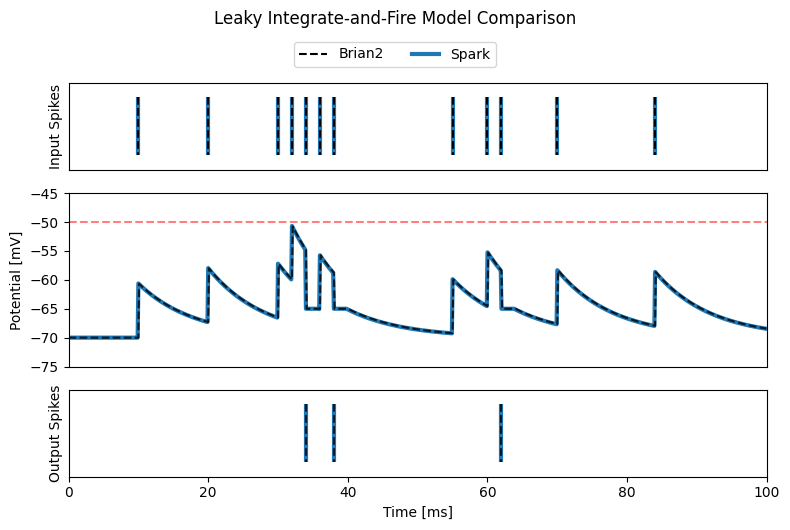

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(8,5), height_ratios=(1,2,1))

ax[0].eventplot(INPUT_SPIKE_TIMES, linewidth=3)
ax[0].eventplot(INPUT_SPIKE_TIMES, color='k', linestyles='--')
ax[0].set_ylabel('Input Spikes')
ax[0].set_ylim(0.25,1.75)
ax[0].set_yticks([], [])
ax[0].set_xticks([], [])

ax[1].plot([0, 100], [FIRING_THRESHOLD, FIRING_THRESHOLD], 'r--', alpha=0.5)
ax[1].plot(spark_times, spark_potentials, linewidth=3)
ax[1].plot(b2_times, b2_potentials, 'k--', alpha=0.8)
ax[1].set_ylabel('Potential [mV]')
ax[1].set_ylim(-75,-45)
ax[1].set_xticks([], [])

ax[2].eventplot(spark_spikes, linewidths=3)
ax[2].eventplot(b2_spikes, color='k', linestyles='--', alpha=0.8)
ax[2].set_ylabel('Output Spikes')
ax[2].set_yticks([], [])
ax[2].set_ylim(0.25,1.75)
ax[2].set_xlabel('Time [ms]')

for i in range(3):
	ax[i].set_xlim(0, spark_times[-1])

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
	Line2D([], [], color='k', linestyle='--', label='Brian2'), 
	Line2D([], [], linestyle='solid', linewidth=3, label='Spark'), 
]
legend = fig.legend(handles=legend_elements, ncols=2, bbox_to_anchor=(0.5, 1.0), loc='upper center')

plt.suptitle('Leaky Integrate-and-Fire Model Comparison', y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
def simulate_LIF_from_spikes(
		spike_times,
		synapse_strength,
		t_max,
		dt,
		v_rest,
		v_reset,
		firing_threshold,
		membrane_resistance,
		membrane_time_scale,
		abs_refractory_period,
	):
	"""
		Simulate a LIF neuron receiving discrete one-step current inputs from spikes.
	"""
	
	# Reset scope
	b2.start_scope()
	# Build discrete current trace from spikes
	times, currents = spikes_to_current(spike_times, k=synapse_strength, t_max=t_max, dt=dt)
	input_current = b2.TimedArray(currents * b2.nA, dt=dt * b2.ms)
	# Build model
	eqs = """
		dv/dt = (-(v - v_rest) + membrane_resistance * input_current(t)) / membrane_time_scale : volt (unless refractory)
	"""
	neuron = b2.NeuronGroup(
		1, model=eqs, reset="v=v_reset", threshold="v>firing_threshold",
		refractory=abs_refractory_period, method="linear"
	)
	# Initialization
	neuron.v = v_rest
	# Monitors
	state_monitor = b2.StateMonitor(neuron, "v", record=True)
	spike_monitor = b2.SpikeMonitor(neuron)
	# Run simulation
	b2.run(t_max * b2.ms)
	# Get outputs
	times = state_monitor.t / b2.ms
	spikes = [s / b2.ms for s in spike_monitor.t]
	potentials = state_monitor.v[0] / b2.mV
	return times, potentials, spikes

/home/nogar/.cython/brian_extensions/_cython_magic_f4505b645ea1e4f196fba368e0e7b07c.cpp:50:10: fatal error: Python.h: No such file or directory
   50 | #include "Python.h"
      |          ^~~~~~~~~~
compilation terminated.
WARNING    Cannot use Cython, a test compilation failed: command '/usr/bin/x86_64-linux-gnu-g++' failed with exit code 1 (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Running simulation for 10. s with 1024 neurons...
Simulation complete.


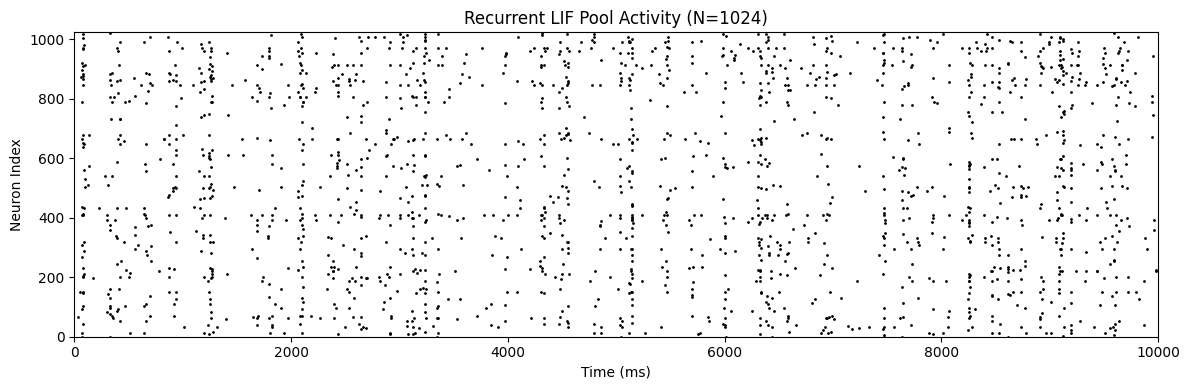

In [ ]:
import brian2 as b2
import matplotlib.pyplot as plt

# --- 1. Set up Simulation Parameters ---

b2.defaultclock.dt = 0.1 * b2.ms  # Set the simulation timestep

N = 1024                # Number of neurons in the pool
N_ext = 256
Nout = 256
T = 10000 * b2.ms        # Total simulation time

# LIF Neuron parameters
tau = 20 * b2.ms       # Membrane time constant
v_rest = -70 * b2.mV   # Resting potential
v_thresh = -50 * b2.mV # Spike threshold
v_reset = -70 * b2.mV  # Reset potential
tau_ref = 5 * b2.ms    # Refractory period

# Synaptic weights
w_ext = 1.0 * b2.mV    # External input weight
w_rec = 0.25 * b2.mV    # Recurrent excitatory weight

# External input
f_ext = 15 * b2.Hz     # Firing rate of the external Poisson input

# --- 2. Define the Neuron Model ---

# Standard LIF neuron equations
lif_eqs = '''
dv/dt = (v_rest - v) / tau : volt (unless refractory)
'''

# --- 3. Create Neuron and Input Groups ---

# The main recurrent population
G = b2.NeuronGroup(
    N,
    lif_eqs,
    threshold='v > v_thresh',
    reset='v = v_reset',
    refractory=tau_ref,
    method='linear'
)  # 'exact' is efficient for linear LIF

# Initialize membrane potentials at rest
G.v = v_rest

# The external "world" input, modeled as an independent
# Poisson spike train for each neuron in G
P_ext = b2.PoissonGroup(Nout, rates=f_ext)


# --- 4. Create Synaptic Connections ---

# External to Group (delta-current synapse)
# Each spike from P_ext[i] causes an instantaneous jump in G.v[i]
S_ext = b2.Synapses(P_ext, G, on_pre='v += w_ext')
S_ext.connect(True, p=(32 / Nout))  # One-to-one connection

# Recurrent (Group to Group)
# All-to-all connectivity, except for self-connections
S_rec = b2.Synapses(G, G, on_pre='v += w_rec')
S_rec.connect(condition='i != j', p=(128 / N))


# --- 5. Set up Monitors to Record Data ---

# Record spikes from the main population
spikemon = b2.SpikeMonitor(G)

# Record voltage of the first 3 neurons

# --- 6. Run the Simulation ---

print(f"Running simulation for {T} with {N} neurons...")
b2.run(T)
print("Simulation complete.")

# --- 7. Plot the Results ---

plt.figure(figsize=(12, 4))

# Plot 1: Raster plot of the recurrent pool
plt.plot(spikemon.t / b2.ms, spikemon.i, '.k', markersize=2)
plt.title(f'Recurrent LIF Pool Activity (N={N})')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.xlim([0, T / b2.ms])
plt.ylim([0, N])
plt.tight_layout()
plt.show()

Running simulation for 5. s with 1024 neurons...
Simulation complete.


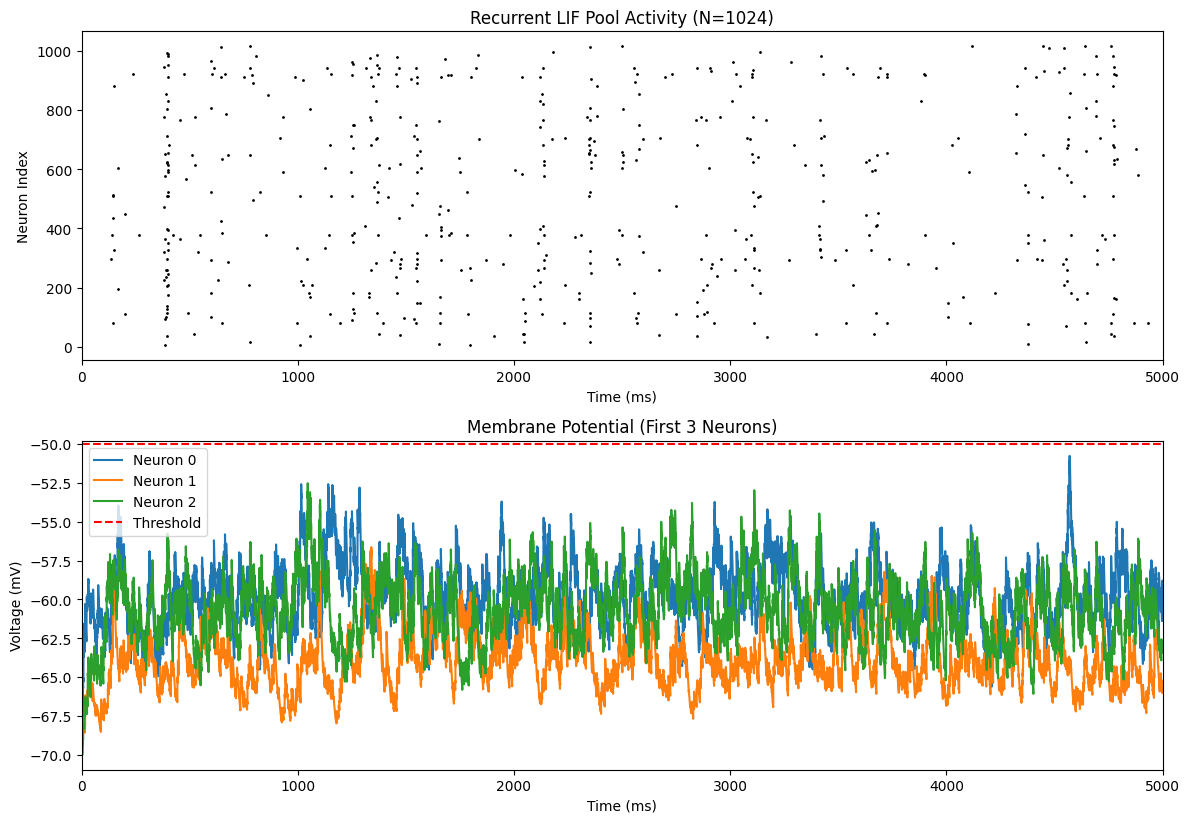

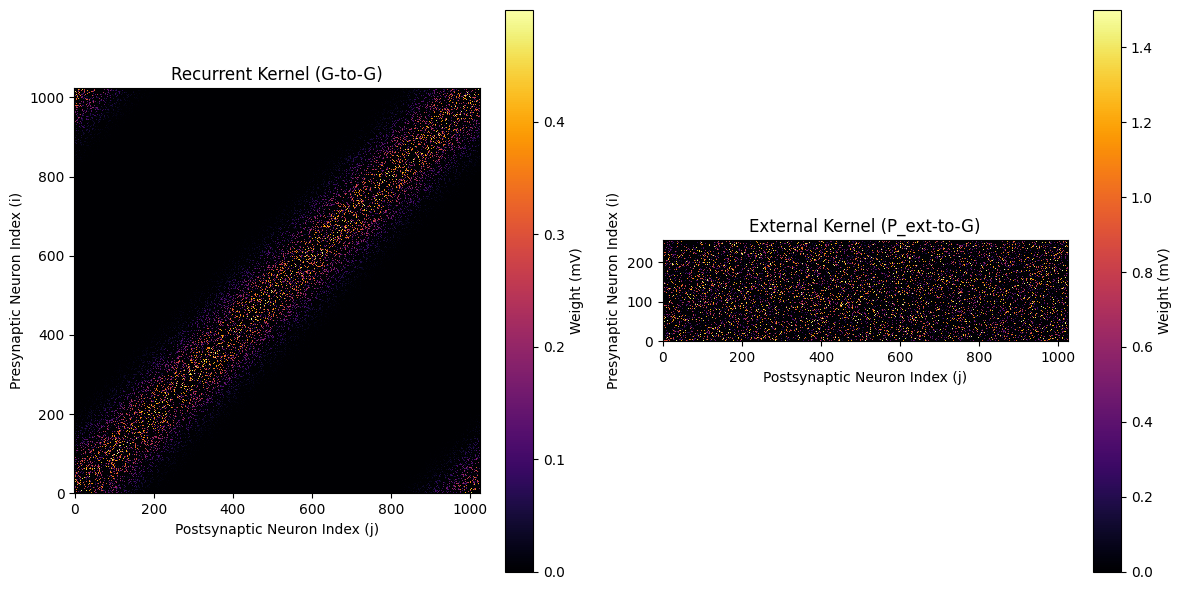

In [ ]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Set up Simulation Parameters ---

b2.defaultclock.dt = 0.1 * b2.ms
N = 1024
N_EXT = 256
T = 5000 * b2.ms

# LIF Neuron parameters
tau = 20 * b2.ms
v_rest = -70 * b2.mV
v_thresh = -50 * b2.mV
v_reset = -70 * b2.mV
tau_ref = 5 * b2.ms

# Synaptic base weights (for scaling)
w_ext_base = 1.5 * b2.mV  # Base weight for external
w_rec_base = 0.5 * b2.mV  # Base weight for recurrent

# External input
f_ext = 15 * b2.Hz

# --- 2. Create Predefined Weight Matrices (Kernels) ---

# --- Recurrent Kernel (G to G) ---
# Let's create an "interesting" kernel: a Gaussian connectivity profile
# Neurons with similar indices are more strongly connected.

# Create a 1D array of neuron indices
neuron_indices = np.arange(N)

# Create 2D distance matrices
# dist_i[i, j] = i
# dist_j[i, j] = j
dist_i, dist_j = np.meshgrid(neuron_indices, neuron_indices)

# Calculate the distance |i - j|
# We use % N to make the connectivity "wrap around" (like a ring)
distance = np.abs(dist_i - dist_j)
distance = np.minimum(distance, N - distance)

# Create a Gaussian (bell curve) kernel
sigma = N / 10  # Standard deviation of the Gaussian
W_rec_matrix = np.exp(-0.5 * (distance / sigma)**2)

# Set the diagonal to 0 (no self-connections)
np.fill_diagonal(W_rec_matrix, 0)

# Scale by the base weight and add units
W_rec_matrix = (W_rec_matrix*W_rec_matrix) * np.random.rand(N, N) * w_rec_base * (np.random.rand(N,N) < (256/N))

# --- External Kernel (P_ext to G) ---
# Let's make this one random.
# Each of the N external channels projects to all N
# neurons in G with a different random weight.
W_ext_matrix = (np.random.rand(N_EXT, N)**2) * w_ext_base * (np.random.rand(N_EXT,N) < (64/N_EXT))


# --- 3. Define the Neuron Model ---
lif_eqs = '''
dv/dt = (v_rest - v) / tau : volt (unless refractory)
'''

# --- 4. Create Neuron and Input Groups ---
G = b2.NeuronGroup(N,
                   lif_eqs,
                   threshold='v > v_thresh',
                   reset='v = v_reset',
                   refractory=tau_ref,
                   method='exact')
G.v = v_rest

P_ext = b2.PoissonGroup(N, rates=f_ext)


# --- 5. Create Synaptic Connections from Matrices ---

# --- External to Group ---
# Define a synaptic parameter 'w_syn'
S_ext = b2.Synapses(P_ext, G,
                   model='w_syn : volt',
                   on_pre='v += w_syn')

# Find all non-zero connections in the matrix
src_ext, tgt_ext = W_ext_matrix.nonzero()

# Create only those synapses
S_ext.connect(i=src_ext, j=tgt_ext)

# Set the weights for the created synapses
S_ext.w_syn = W_ext_matrix[src_ext, tgt_ext]


# --- Recurrent (Group to Group) ---
S_rec = b2.Synapses(G, G,
                   model='w_syn : volt',
                   on_pre='v += w_syn')

# Find all non-zero connections
src_rec, tgt_rec = W_rec_matrix.nonzero()

# Create only those synapses
S_rec.connect(i=src_rec, j=tgt_rec)

# Set the weights
S_rec.w_syn = W_rec_matrix[src_rec, tgt_rec]


# --- 6. Set up Monitors ---
spikemon = b2.SpikeMonitor(G)
statemon = b2.StateMonitor(G, 'v', record=[0, 1, 2])

# --- 7. Run the Simulation ---
print(f"Running simulation for {T} with {N} neurons...")
b2.run(T)
print("Simulation complete.")

# --- 8. Plot Results (Raster and Voltage) ---
plt.figure(figsize=(12, 12))

# Plot 1: Raster plot
plt.subplot(3, 1, 1)
plt.plot(spikemon.t / b2.ms, spikemon.i, '.k', markersize=2)
plt.title(f'Recurrent LIF Pool Activity (N={N})')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.xlim([0, T / b2.ms])

# Plot 2: Voltage traces
plt.subplot(3, 1, 2)
plt.plot(statemon.t / b2.ms, statemon.v.T / b2.mV)
plt.axhline(v_thresh / b2.mV, ls='--', color='r', label='Threshold')
plt.title('Membrane Potential (First 3 Neurons)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend([f'Neuron {i}' for i in statemon.record] + ['Threshold'])
plt.xlim([0, T / b2.ms])

plt.tight_layout()
plt.show()

# --- 9. Plot the Kernels ---
plt.figure(figsize=(12, 6))

# Plot the recurrent kernel
plt.subplot(1, 2, 1)
plt.imshow(W_rec_matrix / b2.mV, cmap='inferno', origin='lower',
           interpolation='none')
plt.colorbar(label='Weight (mV)')
plt.title('Recurrent Kernel (G-to-G)')
plt.xlabel('Postsynaptic Neuron Index (j)')
plt.ylabel('Presynaptic Neuron Index (i)')

# Plot the external kernel
plt.subplot(1, 2, 2)
plt.imshow(W_ext_matrix / b2.mV, cmap='inferno', origin='lower',
           interpolation='none')
plt.colorbar(label='Weight (mV)')
plt.title('External Kernel (P_ext-to-G)')
plt.xlabel('Postsynaptic Neuron Index (j)')
plt.ylabel('Presynaptic Neuron Index (i)')

plt.tight_layout()
plt.show()

In [6]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import time

def run_simulation(
    n,
    n_ext,
    kernel_rec,
    kernel_ext,
    t,
    dt,
):
    # Reset scope
    b2.start_scope()
    t = t * b2.ms
    dt = dt * b2.ms
    b2.defaultclock.dt = dt
    # LIF Neuron parameters
    tau = 20 * b2.ms
    v_rest = -70 * b2.mV
    v_thresh = -50 * b2.mV
    v_reset = -70 * b2.mV
    tau_ref = 5 * b2.ms

    # External input
    f_ext = 15 * b2.Hz

    # Neuron Model
    lif_eqs = '''
        dv/dt = (v_rest - v) / tau : volt (unless refractory)
    '''
    # Neuron and Input Groups
    G = b2.NeuronGroup(n,
                    lif_eqs,
                    threshold='v > v_thresh',
                    reset='v = v_reset',
                    refractory=tau_ref,
                    method='exact')
    G.v = v_rest
    P_ext = b2.PoissonGroup(n_ext, rates=f_ext)

    # External synaptic Connections
    S_ext = b2.Synapses(P_ext, G, model='w_syn : volt', on_pre='v += w_syn')
    src_ext, tgt_ext = W_ext_matrix.nonzero()
    S_ext.connect(i=src_ext, j=tgt_ext)
    S_ext.w_syn = W_ext_matrix[src_ext, tgt_ext] * b2.mV

    # Recurrent synaptic Connections
    S_rec = b2.Synapses(G, G, model='w_syn : volt', on_pre='v += w_syn')
    src_rec, tgt_rec = W_rec_matrix.nonzero()
    S_rec.connect(i=src_rec, j=tgt_rec)
    S_rec.w_syn = W_rec_matrix[src_rec, tgt_rec] * b2.mV

    start = time.time()
    b2.run(t)
    end = time.time()
    return end - start

In [7]:
n = 1024
n_ext = 256
# Synaptic base weights (for scaling)
w_ext_base = 1.5  # Base weight for external
w_rec_base = 0.5  # Base weight for recurrent
sigma = n / 10  # Standard deviation of the Gaussian
# --- Kernels ---
neuron_indices = np.arange(n)
dist_i, dist_j = np.meshgrid(neuron_indices, neuron_indices)
distance = np.abs(dist_i - dist_j)
distance = np.minimum(distance, n - distance)
W_rec_matrix = np.exp(-0.5 * (distance / sigma)**2)
np.fill_diagonal(W_rec_matrix, 0)
W_rec_matrix = (W_rec_matrix*W_rec_matrix) * np.random.rand(n, n) * w_rec_base * (np.random.rand(n,n) < (256/n))
W_ext_matrix = (np.random.rand(n_ext, n)**2) * w_ext_base * (np.random.rand(n_ext,n) < (64/n_ext))


In [8]:
run_simulation(
    n = 1024,
    n_ext = 256,
    kernel_rec = W_rec_matrix,
    kernel_ext = W_ext_matrix,
    t = 5000,
    dt = 0.1,
)

WARNING    'dt' is an internal variable of group 'poissongroup_1', but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


1.3161916732788086